### importing necessary libraries

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,BooleanType
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SparkSession.stop(spark)
spark=SparkSession.builder.appName("BigData").getOrCreate()

### Loading our dataset from hdfs
### Preprocessed_business.csv and review.csv

In [3]:
business=spark.read.option("header","true").option("inferSchema","true").csv('hdfs://127.0.0.1:9000/input/preprocessed_business.csv',sep='^')
review=spark.read.option("header","true").option("inferSchema","true").option("multiLine","true").csv('hdfs://127.0.0.1:9000/input/review.csv',sep=',')

### Lets see what our business dataset looks like

In [4]:
business.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = true)



### One row from our business dataset

In [5]:
business.show(1)

+--------------------+--------------------+------------+------------------+--------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+
|         business_id|                name|neighborhood|           address|          city|state|postal_code|  latitude|  longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+------------------+--------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+
|PfOCPjBrlQAnz__NX...|"""Brick House Ta...|        null|"""581 Howe Ave"""|Cuyahoga Falls|   OH|      44221|41.1195346|-81.4756898|  3.5|         116|      1|American (New);Ni...|
+--------------------+--------------------+------------+------------------+--------------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+
only showing top 1 row



### Now lets look at our review dataset

In [6]:
review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)



In [7]:
review.show(1)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
only showing top 1 row



### Now lets start our analysis

### Lets group the businesses based on their average rating

In [8]:
business.groupby("stars").count().show()

+-----+-----+
|stars|count|
+-----+-----+
|  3.5|13391|
|  4.5| 6519|
|  2.5| 5448|
|  1.0|  348|
|  4.0|13529|
|  3.0| 9826|
|  2.0| 2946|
|  1.5| 1131|
|  5.0| 1492|
+-----+-----+



/home/ajitesh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


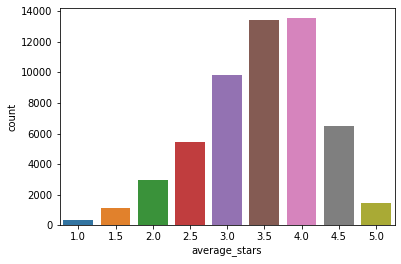

In [19]:
reviewcount=business.groupby("average_stars").count().toPandas()
sns.barplot(reviewcount['average_stars'],reviewcount['count'])
plt.show()

### Both our datasets contain the attribute stars.So lets rename it

In [9]:
business=business.withColumnRenamed("stars","average_stars")

### Now we are gong to merge the two datasets.
### We are going to perform inner join on the datasets based on the common attribute business_id

In [10]:
data=business.join(review,["business_id"],how = "inner")

### This is what our merged dataset looks like

In [11]:
data.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)



### Now we fill NA values of categorical variables as an empty string and numeric variables as 0

In [12]:
data=data.na.fill("",subset=['business_id','name','neighborhood','address','city','state','postal_code','categories','review_id','user_id','date','text'])
data=data.na.fill(0,subset=['latitude','longitude','average_stars','review_count','is_open','stars','useful','funny','cool'])

### Now lets look at some reviews of restaurants from the state of Ohio using our merged dataset

In [49]:
ohio=data[data['state']=="OH"].select('text').limit(5)
ohio.show()

+--------------------+
|                text|
+--------------------+
|Solid beers -- Ch...|
|Great vibe + loud...|
|The food is alway...|
|Had a variety of ...|
|Food was pretty t...|
+--------------------+



### Now lets count the number of restaurants in each city

In [13]:
city_business=business.groupby('city').count()
city_business=city_business.groupby('city').sum()


In [14]:
city_business=city_business.sort('sum(count)',ascending=False)
city_business.show(5)

+---------+----------+
|     city|sum(count)|
+---------+----------+
|  Toronto|      7148|
|Las Vegas|      5902|
|  Phoenix|      3652|
| Montréal|      3332|
|Charlotte|      2461|
+---------+----------+
only showing top 5 rows



Text(0.5, 1.0, 'Number of all Restaurants in every city')

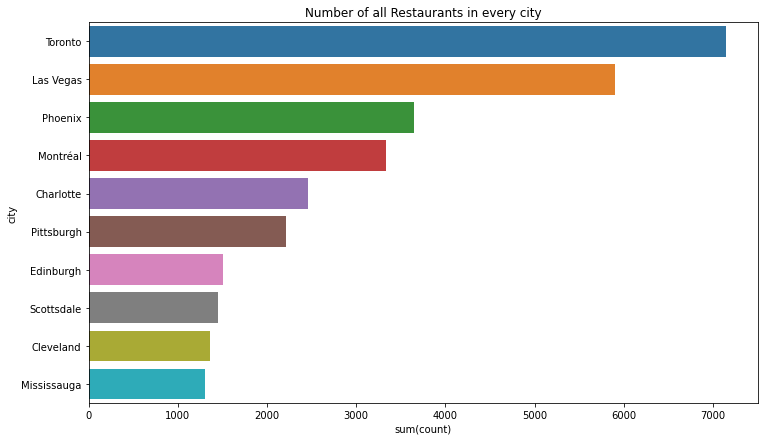

In [15]:
city_business=city_business.limit(10).toPandas()
plt.figure(figsize=(12,7))
sns.barplot(y='city',x='sum(count)',data=city_business)
plt.title('Number of all Restaurants in every city')

### Distribution of Review Count

Text(0.5, 1.0, 'Businesses by Review Count')

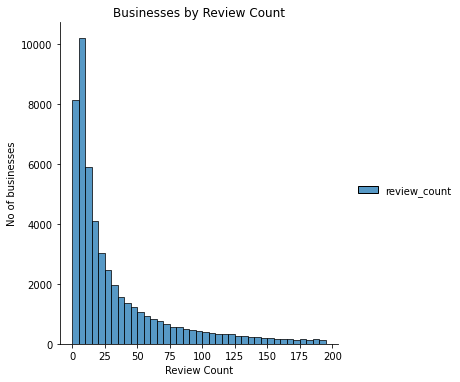

In [16]:
reviewcount=business.select('review_count').toPandas()
sns.displot(reviewcount,bins=range(0,200,5))
plt.xlabel('Review Count')
plt.ylabel('No of businesses')
plt.title('Businesses by Review Count')

### Lets analyse the reviews marked as useful,cool and funny

In [17]:
useful_review=review[review['useful']=='1'].count()
cool_review=review[review['cool']=='1'].count()
funny_review=review[review['funny']=='1'].count()

/home/ajitesh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


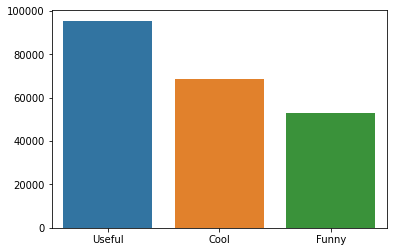

In [18]:
x=['Useful','Cool','Funny']
y=[useful_review,cool_review,funny_review]
sns.barplot(x,y)
plt.show()

### Lets analyse the reviews based on rating
### We select 1000 reviews from our dataset which had the rating of 1/5.This will be considered as negative reviews.
### Similarly we consider 5/5 stars as positive reviews.

In [29]:
stars_review1=review[review['stars']=='1'].select('stars','text').limit(1000).toPandas()
stars_review5=review[review['stars']=='5'].select('stars','text').limit(1000).toPandas()

### Lets replace NA values with empty string

In [30]:
stars_review1['text'].fillna('',inplace=True)
stars_review5['text'].fillna('',inplace=True)

### Now we remove Punctuations,Digits and special characters

In [31]:
import re
def remove_punctuation_digits_specialchar(line):
    return re.sub('[^A-Za-z]+',' ',line).lower()

In [32]:
stars_review1['clean_review']=stars_review1['text'].apply(remove_punctuation_digits_specialchar)
stars_review1[['text','clean_review']].head()

,text,clean_review
0,I thought Tidy's Flowers had a great reputatio...,i thought tidy s flowers had a great reputatio...
1,I too have been trying to book an appt to use ...,i too have been trying to book an appt to use ...
2,really excited to hear of this restaurant comi...,really excited to hear of this restaurant comi...
3,Food is very bland - not authentic at all.\n\n...,food is very bland not authentic at all meant ...
4,If you have not yet tried Wasabi - don't bothe...,if you have not yet tried wasabi don t bother ...


In [33]:
stars_review5['clean_review']=stars_review5['text'].apply(remove_punctuation_digits_specialchar)

### Now we remove the stop words

In [34]:
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
def tokenize_no_stopwords(line):
    tokens=nltk.tokenize.word_tokenize(line)
    tokens_no_stop=[w for w in tokens if w not in stopwords.words('english')]
    return " ".join(tokens_no_stop)

In [35]:
stars_review1['final_review']=stars_review1['clean_review'].apply(tokenize_no_stopwords)
stars_review1[['clean_review','final_review']].head()

,clean_review,final_review
0,i thought tidy s flowers had a great reputatio...,thought tidy flowers great reputation florist ...
1,i too have been trying to book an appt to use ...,trying book appt use voucher months countless ...
2,really excited to hear of this restaurant comi...,really excited hear restaurant coming toronto ...
3,food is very bland not authentic at all meant ...,food bland authentic meant cater customers nev...
4,if you have not yet tried wasabi don t bother ...,yet tried wasabi bother expensive food disgust...


In [36]:
stars_review5['final_review']=stars_review5['clean_review'].apply(tokenize_no_stopwords)

### Now lets look at the 200 most commonly used words in negative reviews using Wordcloud

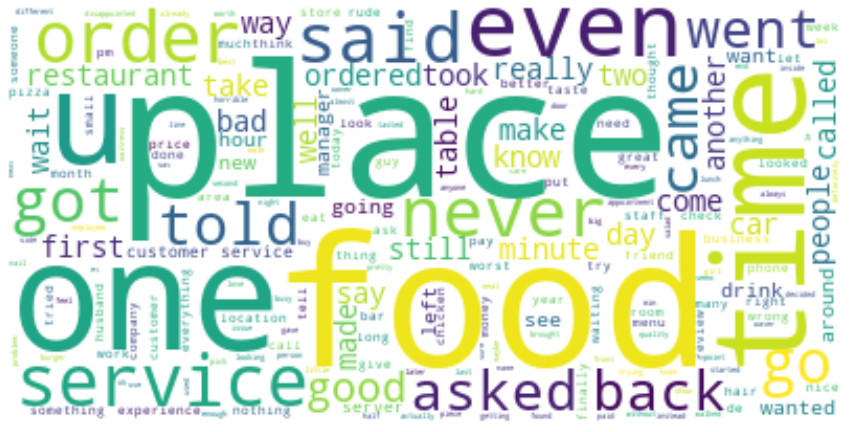

In [38]:
import wordcloud
from wordcloud import WordCloud,ImageColorGenerator
text=" ".join(str(each) for each in stars_review1.final_review)
wordcloud=WordCloud(max_words=200,background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()
pass

### And the 200 most common words used in positive reviews.

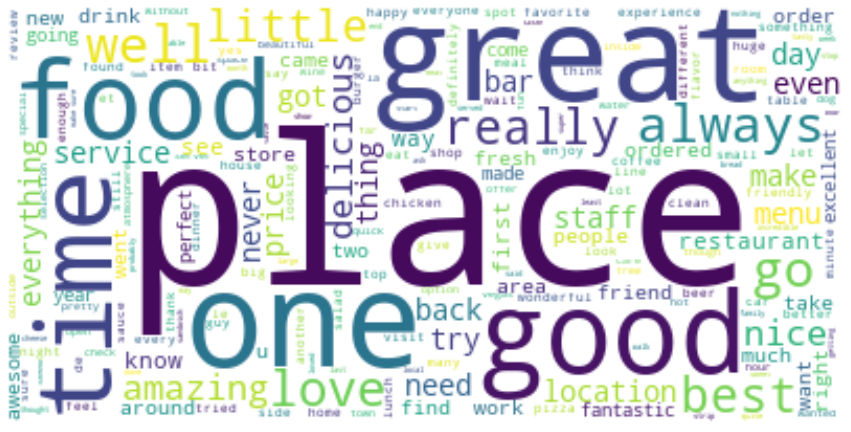

In [39]:
text=" ".join(str(each) for each in stars_review5.final_review)
wordcloud=WordCloud(max_words=200,background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()
pass